#  Recycler Simulation

In [2]:
import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_context('talk')

import copy

from scipy.constants import c, e, m_p

import PyHEADTAIL

from FERMImachines import RR

from PyHEADTAIL.particles.slicing import UniformBinSlicer
from PyHEADTAIL.impedances.wakes import CircularResistiveWall, CircularResonator, WakeField, WakeTable

PyHEADTAIL v1.16.0


1
Synchrotron init. From kwargs: n_segments = 1
Synchrotron init. From kwargs: machine_configuration = '53MHz'
Synchrotron init. From kwargs: longitudinal_focusing = 'non-linear'
*** Maximum RMS bunch length 0.889766948349279m.


c:\Users\bengl\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\integrate\_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


... distance to target bunch length: -5.6249e-01
... distance to target bunch length: 2.9519e-01
... distance to target bunch length: 2.6026e-01
... distance to target bunch length: 6.0106e-02
... distance to target bunch length: -8.4604e-02
... distance to target bunch length: 6.0186e-03
... distance to target bunch length: -1.5995e-04
... distance to target bunch length: 1.2451e-06
... distance to target bunch length: -1.5136e-06
--> Bunch length: 0.5700012450826168
--> Emittance: 0.06445306419261544
dipole_x Assuming ultrarelativistic wake.
*** PyHEADTAIL WARNING! You use multiturn wakes. The stored SliceSet instances from previous turns are converted from z to dt according to the current turn's gamma. If you accelerate this is only an approximation which becomes invalid when gamma changes much over n_turns_wake.
dipole_y Assuming ultrarelativistic wake.
*** PyHEADTAIL WARNING! You use multiturn wakes. The stored SliceSet instances from previous turns are converted from z to dt acco

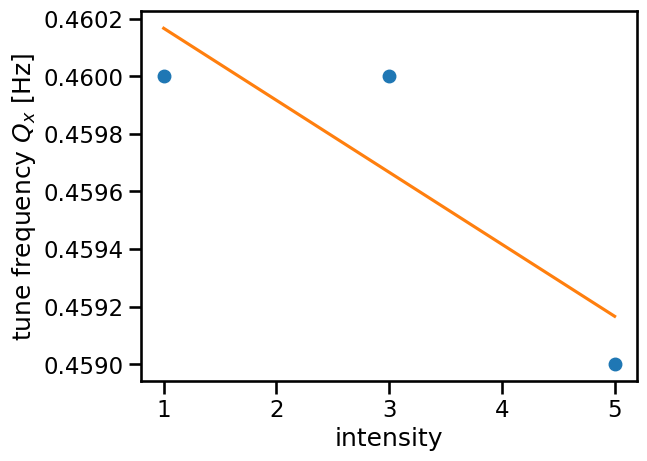

In [3]:
intensities =np.array([1,3,5])
tune_freqs = []
n_turns = 1000

for i, intensity in enumerate(intensities):
    print(intensity)
    machine = RR(n_segments=1, machine_configuration='53MHz', 
                longitudinal_focusing='non-linear')

    C = machine.circumference

    epsn_x = epsn_y = 2.5e-6 # in [m rad]

    bunch = machine.generate_6D_Gaussian_bunch_matched(
        n_macroparticles=int(1e5), intensity=intensity*1e11, 
        epsn_x=epsn_x, epsn_y=epsn_y, sigma_z=0.57)

    n_sigma_z = 2
    n_slices = 50
    uniform_bin_slicer = UniformBinSlicer(n_slices=n_slices, n_sigma_z=n_sigma_z)

    #wake_table = CircularResonator(R_shunt=1e6, frequency=1e9, Q=1)

    wakefile = 'RR_fullWake_resistiveWall_PyHTConvention.dat'
    wake_table = WakeTable(wakefile, ['time', 'dipole_x', 'dipole_y', 'quadrupole_x', 'quadrupole_y','nonsense'],n_turns_wake=5)   # Follow the order of the columns in the wake file here. If you want to exclude a component, change the name e.g. for the dipole y to 'no_dipole_y'.
    wake_field = WakeField(uniform_bin_slicer, wake_table) #, wake_table_k, wake_table_k)
    
    #wake_table = CircularResistiveWall(pipe_radius=5e-2, resistive_wall_length=C, conductivity=3e9, dt_min=1e-3/c, beta=bunch.beta, n_turns_wake=100)
    #wake_field = WakeField(uniform_bin_slicer, wake_table)
    machine.one_turn_map.append(wake_field)
    
    m_x = []
    m_y = []
    
    for i in range(n_turns):
        machine.track(bunch)
        m_x.append(bunch.mean_x())
        m_y.append(bunch.mean_y())
        if i % 100 == 0:
            print(i)

    m_x = np.array(m_x)
    m_y = np.array(m_y)

    ytune= (np.argmax(np.abs(np.fft.fft(m_y)))/float(n_turns))
    xtune= (np.argmax(np.abs(np.fft.fft(m_x)))/float(n_turns))

    if ytune > 0.5:
        ytune = (1-ytune)
        
    if xtune > 0.5:
        xtune = (1-xtune)

    tune_freqs.append(xtune)

plt.plot(intensities, tune_freqs, 'o')
plt.xlabel('intensity')
plt.ylabel('tune frequency $Q_x$ [Hz]')
a,b = np.polyfit(intensities, tune_freqs, 1)
plt.plot(intensities,  intensities*a+b, label='linear fit')
plt.show()